In [92]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis(False)

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis(False)

### What is a Convolution?


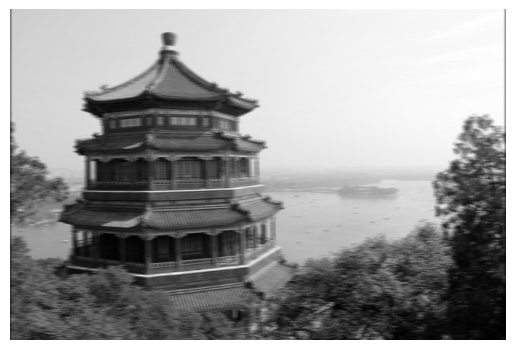

In [3]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis(False)
plt.show()

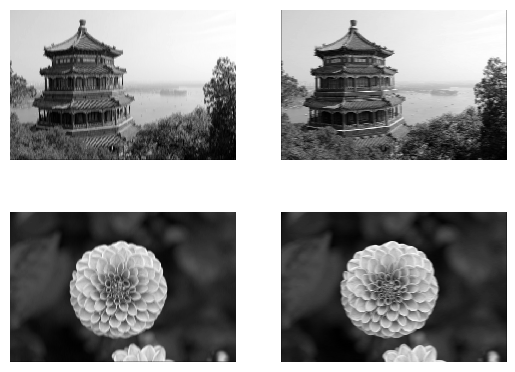

In [4]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

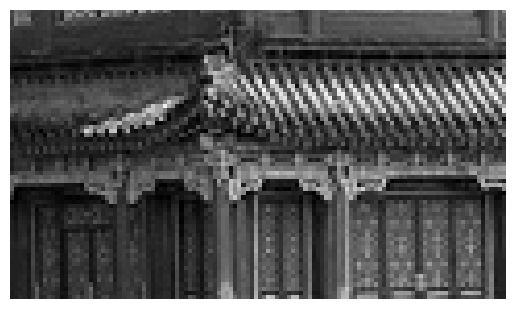

china_vertical


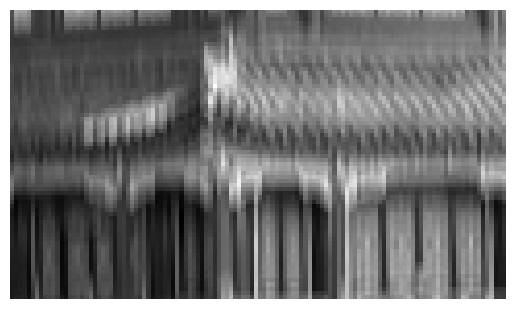

china_horizontal


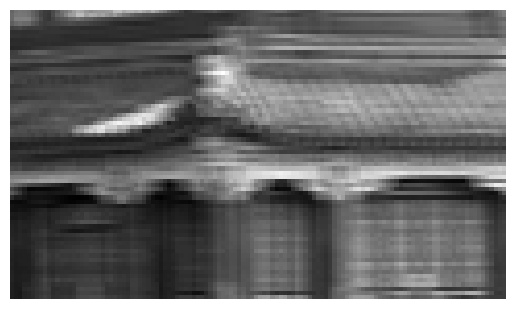

In [6]:
plot_image(crop(images[0,:,:,0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    print(filename)
    plot_image(crop(outputs[0,:,:, feature_map_index]))
    plt.show()

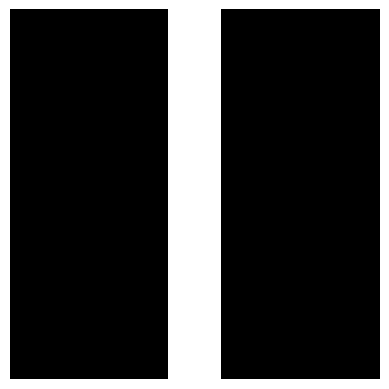

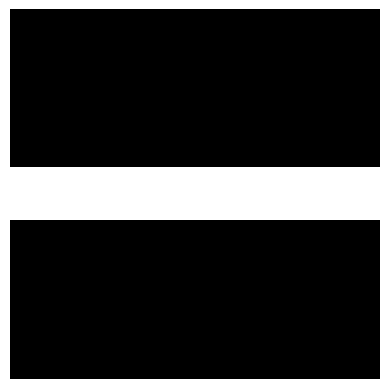

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### Convolutional Layer


In [8]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

In [10]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [11]:
conv.set_weights([filters, np.zeros(2)])

In [12]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

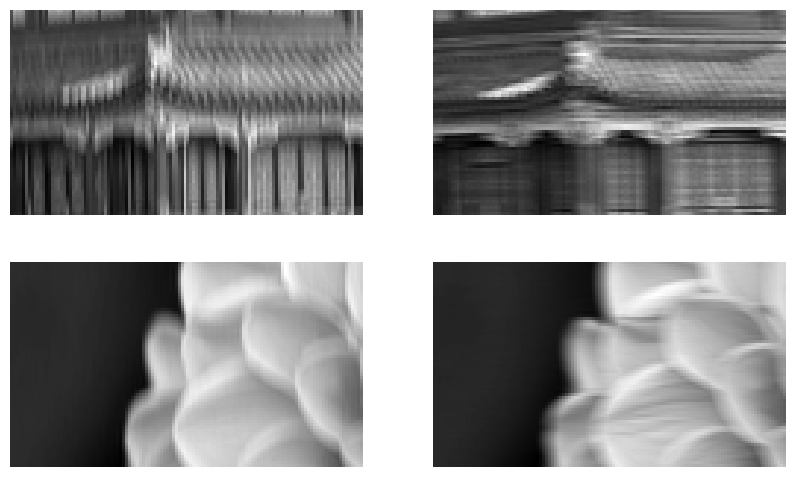

In [13]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

### Pooling layer


#### Max pooling

In [17]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [18]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

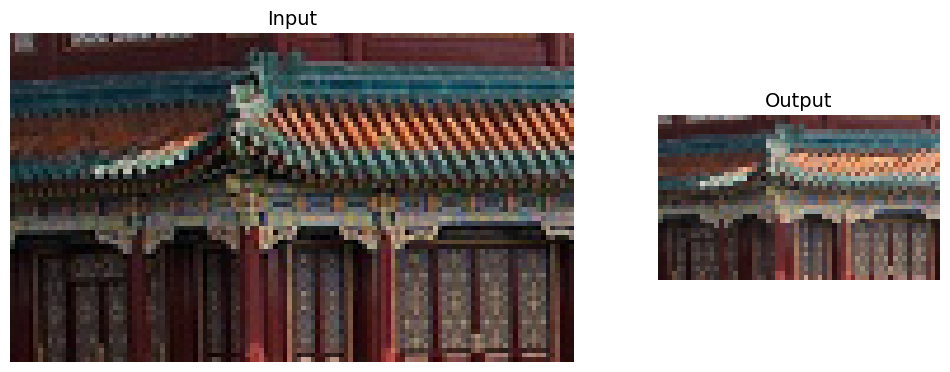

In [19]:
import matplotlib as mlp

fig = plt.figure(figsize = (12,8))
gs = mlp.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis(False)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output",fontsize=14)
ax2.imshow(output[0])
ax2.axis(False)
plt.show()

#### Depth-wise pooling


In [20]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1,1,1, self.pool_size),
                              strides=(1,1,1, self.pool_size),
                              padding=self.padding)

In [21]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

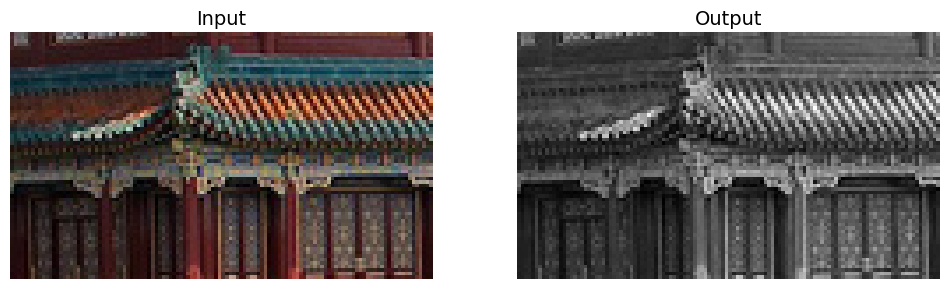

In [22]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis(False)
plt.show()

#### Average pooling


In [23]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [24]:
output_avg = avg_pool(cropped_images)

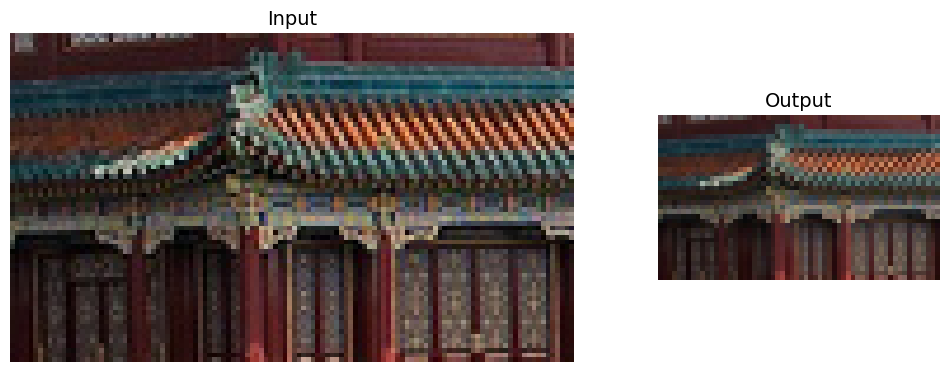

In [25]:
fig = plt.figure(figsize=(12, 8))
gs = mlp.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

#### Global Average Pooling


In [26]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [27]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

### Tackling Fashion MNIST With a CNN


In [29]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation="relu",padding="SAME")

In [31]:
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
    keras.layers.MaxPool2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPool2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

In [32]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.Nadam(),metrics=['accuracy'])
history_ = model.fit(X_train,y_train, epochs=10, validation_data=(X_valid,y_valid))
score = model.evaluate(X_test,y_test)
X_new = X_test[:10] # new for instance
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.6241 - loss: 1.0498 - val_accuracy: 0.8540 - val_loss: 0.4207
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8512 - loss: 0.4475 - val_accuracy: 0.8776 - val_loss: 0.3394
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8694 - loss: 0.3847 - val_accuracy: 0.8896 - val_loss: 0.3041
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8872 - loss: 0.3363 - val_accuracy: 0.8870 - val_loss: 0.3251
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8946 - loss: 0.3206 - val_accuracy: 0.8970 - val_loss: 0.3073
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8954 - loss: 0.3059 - val_accuracy: 0.8920 - val_loss: 0.3011
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9024 - loss: 0.2873 - val_accuracy: 0.9006 - val_loss: 0.2996
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9067 - loss: 

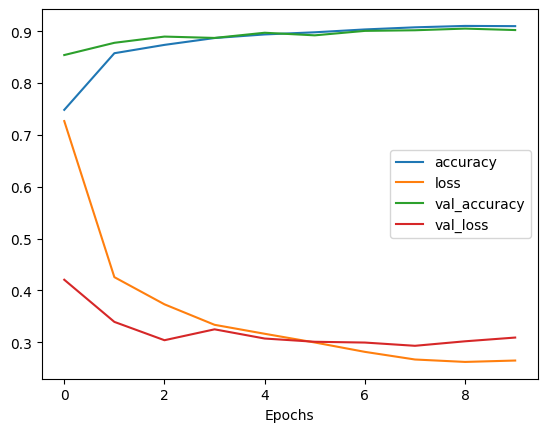

In [33]:
import pandas as pd

pd.DataFrame(history_.history).plot()
plt.xlabel("Epochs")
plt.show()

### ResNet-34

In [34]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters,strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layer = []
        if strides > 1:
            self.skip_layer = [
                DefaultConv2D(filters, strides=strides, kernel_size=1),
                keras.layers.BatchNormalization()]

    def call(self,inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layer:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides =1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,664 (37.75 KB)

 Trainable params: 9,536 (37.25 KB)

 Non-trainable params: 128 (512.00 B)

### Using a Pretrained Model

In [38]:
model = keras.applications.resnet50.ResNet50(weights = "imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


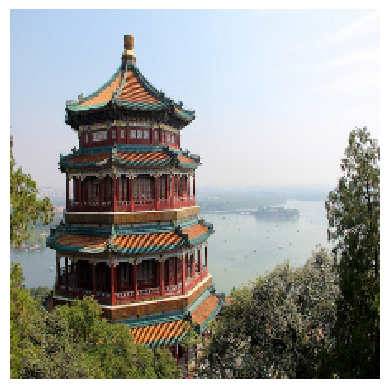

In [39]:
resized_images = tf.image.resize(images, [224,224])
plot_color_image(resized_images[0])
plt.show()

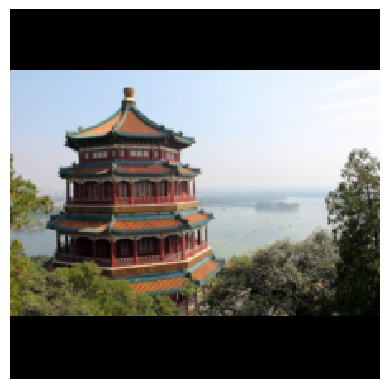

In [40]:
resized_images = tf.image.resize_with_pad(images, 224,224, antialias=True)
plot_color_image(resized_images[0])

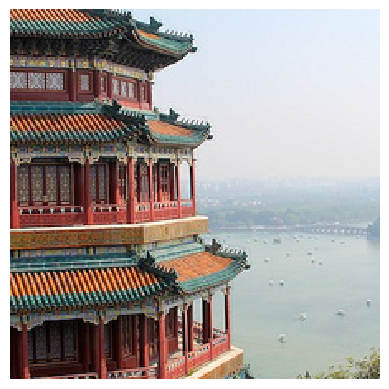

In [41]:
resized_images = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(resized_images[0])

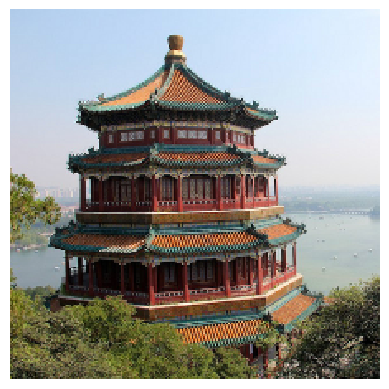

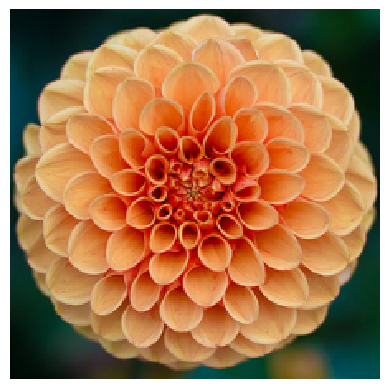

In [42]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
resized_images = tf.image.crop_and_resize(images, [china_box, flower_box], [0,1], [224, 224])
plot_color_image(resized_images[0])
plt.show()
plot_color_image(resized_images[1])
plt.show()

In [43]:
inputs = keras.applications.resnet50.preprocess_input(resized_images * 255)
Y_proba = model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [44]:
Y_proba.shape

(2, 1000)

In [45]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Images#{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id,name,y_proba * 100))
    print()

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Images#0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Images#1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



### Pretrained Models for Transfer Learning

In [46]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [52]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [53]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [55]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [56]:
n_classes = info.features["label"].num_classes
n_classes

5

In [57]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [58]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

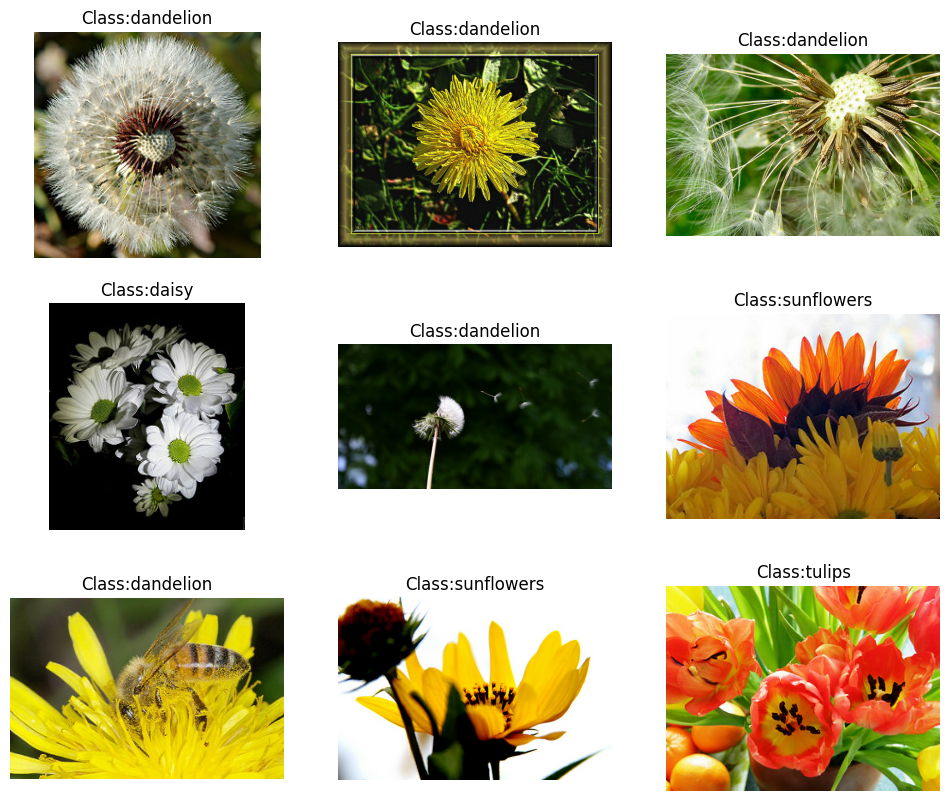

In [63]:
plt.figure(figsize=(12,10))
index = 0
for image, label in train_set_raw.take(9):
    index+=1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title(f"Class:{class_names[label]}")
    plt.axis(False)
plt.show()

#### Basic preprocessing:


In [64]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_images)
    return image, label

In [70]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [71]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

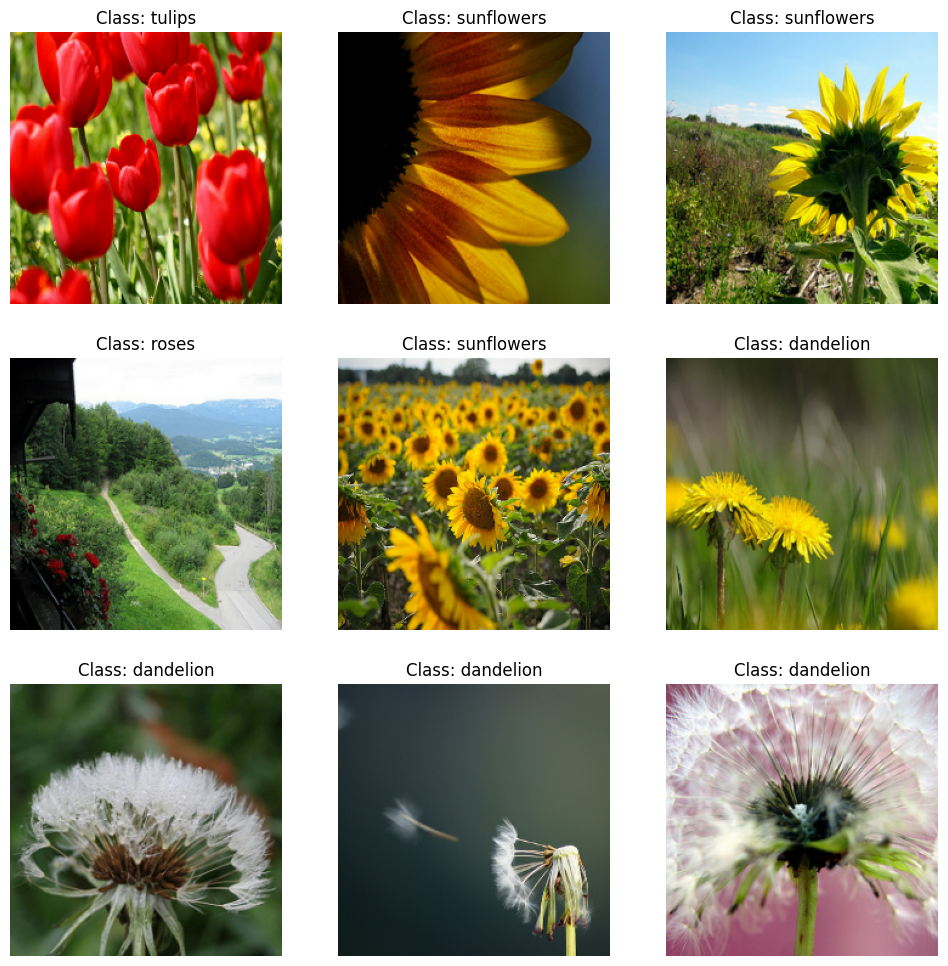

In [73]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [74]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [76]:
for index, layer in enumerate(base_model.layers):
    print(index, layer)

0 <InputLayer name=input_layer_3, built=True>
1 <Conv2D name=block1_conv1, built=True>
2 <BatchNormalization name=block1_conv1_bn, built=True>
3 <Activation name=block1_conv1_act, built=True>
4 <Conv2D name=block1_conv2, built=True>
5 <BatchNormalization name=block1_conv2_bn, built=True>
6 <Activation name=block1_conv2_act, built=True>
7 <SeparableConv2D name=block2_sepconv1, built=True>
8 <BatchNormalization name=block2_sepconv1_bn, built=True>
9 <Activation name=block2_sepconv2_act, built=True>
10 <SeparableConv2D name=block2_sepconv2, built=True>
11 <BatchNormalization name=block2_sepconv2_bn, built=True>
12 <Conv2D name=conv2d_7, built=True>
13 <MaxPooling2D name=block2_pool, built=True>
14 <BatchNormalization name=batch_normalization_1, built=True>
15 <Add name=add, built=True>
16 <Activation name=block3_sepconv1_act, built=True>
17 <SeparableConv2D name=block3_sepconv1, built=True>
18 <BatchNormalization name=block3_sepconv1_bn, built=True>
19 <Activation name=block3_sepconv2_act

In [79]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=optimizer,
              metrics=["accuracy"])

history_ = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - accuracy: 0.7275 - loss: 1.4688 - val_accuracy: 0.8051 - val_loss: 1.5460
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.8660 - loss: 0.9626 - val_accuracy: 0.8401 - val_loss: 1.2584
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.8951 - loss: 0.6636 - val_accuracy: 0.8272 - val_loss: 1.9152
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.9125 - loss: 0.6828 - val_accuracy: 0.8235 - val_loss: 1.7192
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.9168 - loss: 0.5161 - val_accuracy: 0.8290 - val_loss: 1.3671


In [ ]:
pd.DataFrame(history_.history).plot()
plt.xlabel("Epochs")
plt.show()

In [80]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 78s 486ms/step - accuracy: 0.8497 - loss: 0.5036 - val_accuracy: 0.8585 - val_loss: 0.5214
Epoch 2/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - accuracy: 0.9517 - loss: 0.1333 - val_accuracy: 0.8915 - val_loss: 0.3498
Epoch 3/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 478ms/step - accuracy: 0.9784 - loss: 0.0648 - val_accuracy: 0.9154 - val_loss: 0.2748
Epoch 4/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9796 - loss: 0.0511 - val_accuracy: 0.8971 - val_loss: 0.3897
Epoch 5/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9822 - loss: 0.0512 - val_accuracy: 0.9136 - val_loss: 0.3173
Epoch 6/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 449ms/step - accuracy: 0.9895 - loss: 0.0302 - val_accuracy: 0.9154 - val_loss: 0.2992
Epoch 7/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.9905 - loss: 0.0194 - val_accuracy: 0.9228 - val_loss: 0.3413
Epoch 8/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.9940 - loss: 0.0229 - val_accuracy: 0.911

### Classification and Localization


In [81]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [82]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

### Mean Average Precision (mAP)


In [85]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

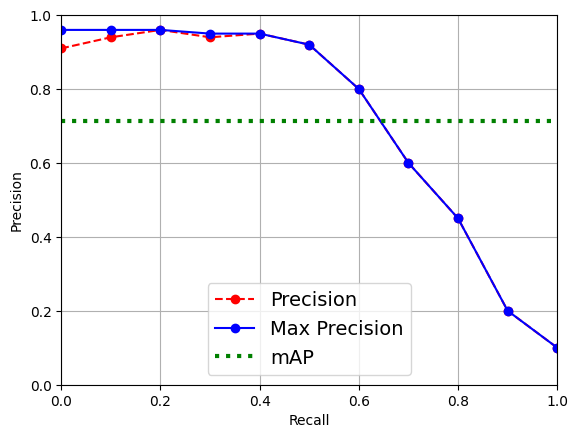

In [86]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [88]:
tf.random.set_seed(42)
X = resized_images.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

In [94]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mlp.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [95]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [96]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

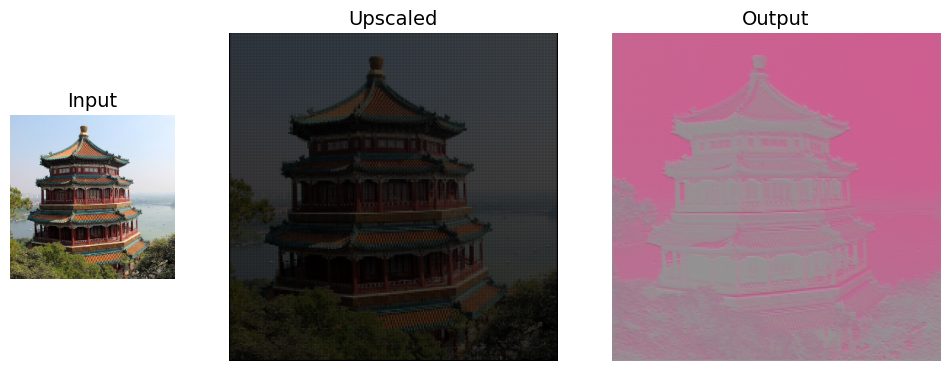

In [98]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mlp.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [99]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True